In [28]:
import cirq
import numpy as np
import scipy
import sympy 
import matplotlib.pyplot as plt
import cirq.experiments.n_qubit_tomography as cen

from functools import reduce


In [15]:
def expZZ(t):
    ''' return the gate exp( -it * ZZ ) '''
       
    return cirq.ZZPowGate(exponent=2*t/np.pi, global_shift=-0.5)
   
def expX(t):
    ''' return the gate exp( -it * X ) '''
    return cirq.XPowGate(exponent=2*t/np.pi, global_shift=-0.5)

def is_Hermitian(M, rtol = 1e-5, atol = 1e-9):
    return np.allclose(M, np.conjugate(M.T), rtol=rtol, atol=atol)

def is_positive(M, tol = 1e-7):
    s = np.linalg.eigvalsh(M)
    assert (s[0] > -tol)
    for i in range(len(s)):
      if s[i] <= 0:
         s[i] = 1e-12
    return s

In [16]:
# define basic Pauli matrices
s_alpha = [np.array([[1,0],[0,1]],dtype=complex),np.array([[0,1],[1,0]],dtype=complex),np.array([[0,-1j],[1j,0]],dtype=complex),np.array([[1,0],[0,-1]],dtype=complex)]


# define the many-body spin operators
def sp(alpha,n,N):
    Sa = s_alpha[alpha]
    for i in range(n):
        Sa = np.kron(s_alpha[0],Sa)
    for j in range(n+1,N):
        Sa = np.kron(Sa,s_alpha[0])
    return Sa



def magn_exact_diagonalization(L,g,t,Npoints):
  # array containing the magnetization of individual basis states
  magnetization_basis_states = -np.array( [np.sum(2*np.array(cirq.big_endian_int_to_bits(val = n, bit_count = L)) - 1.0)/L for n in range(2**L)] )

  # create the hamiltonian
  hamiltonian = np.zeros((2**L,2**L),dtype=complex)
  for i in range(L):
      hamiltonian += g/2*sp(1,i,L)
      if i != L-1:
          hamiltonian += -1/2*sp(3,i,L)@sp(3,i+1,L)
  
  # diagonalize
  E,V = np.linalg.eig(hamiltonian)

  # time evolve
  magnetization = np.zeros(Npoints)
  initial_state = np.array([int(n==0) for n in range(2**L)])
  overlap = V.transpose().conj() @ initial_state
  for ind,T in enumerate(np.linspace(0,t,Npoints)):
    state_evolved = V @ (np.exp(-1j*T*E) * overlap)
    magnetization[ind] = np.sum(magnetization_basis_states * np.abs(state_evolved)**2)
  
  return magnetization

In [17]:
# System size
L = 10


# System initialization
chain = cirq.GridQubit.rect(1,L)


# Create a circuit
circuit_dummy = cirq.Circuit()
circuit_dummy.append(cirq.I(q) for q in chain)


# Simulate the wave function ...
result_exact = cirq.Simulator().simulate(circuit_dummy)

# ... and extract relevant objects
state = result_exact.state_vector()
state = state/np.linalg.norm(state) # in case not normalized for large system
print(state)
rho = result_exact.density_matrix_of(chain[ round(L/2):L ])

# compute an observable that consists of a sum of Pauli matrices
Paulix = cirq.PauliSum.from_pauli_strings([cirq.X(q) for q in chain])
q_map = result_exact.qubit_map
x_magntization = Paulix.expectation_from_state_vector(state, q_map).real/L

print(x_magntization)

# Perform repeated measurements ...
repetition = 100
circuit_measurement = cirq.Circuit()
circuit_measurement.append(circuit_dummy)
circuit_measurement.append( [cirq.measure(q) for q in chain], strategy = cirq.InsertStrategy.NEW_THEN_INLINE)  
result_measure = cirq.Simulator().run(circuit_measurement, repetitions = repetition)
# ... and extract relevant observables
keys = [f'(0, {i})' for i in range(L)]
counts = result_measure.multi_measurement_histogram(keys = keys)
key0 = tuple( [0] * L )
probability_0 = counts[key0]/repetition # probability_0 = 1 for circuit_dummy



# Tomography experiments
tomo_qubits = chain[round(L/2):L]
tomo_repetition = 1000
exp = cen.StateTomographyExperiment(tomo_qubits)
sam = cirq.Simulator()
probs = cen.get_state_tomography_data(sam, tomo_qubits, circuit_dummy, exp.rot_circuit, exp.rot_sweep, repetitions=tomo_repetition)
tomo_density_matrix = exp.fit_density_matrix(probs)._density_matrix # extract the density matrix from the probabilities (Linear Inversion)



# Also useful: convert numbers into bitstrings and vice versa
bit_string0 = [0] * L
number = cirq.big_endian_bits_to_int(bit_string0)
bit_string1 = cirq.big_endian_int_to_bits(val = number, bit_count = L)
print( bit_string0 == bit_string1 ) # True

[1.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
0.0
True


In [118]:
def evolve_basic(circ,qubits,g,dt):
    """ one step time evolution of qubits in circ by dt 
    through first order approximation"""
   
    ta = -g*dt/2
    Ua = expX(ta)
    
    tb = -dt/2
    Ub = expZZ(tb)

    N = len(qubits)

    for i in range(0,N,2): # even sites
        circ.append(Ub(qubits[i],qubits[i+1]))

    for i in range(1,N-1,2): # odd sites
        circ.append(Ub(qubits[i],qubits[i+1]))
    
    for qubit in qubits:
        circ.append(Ua(qubit)) # e^A = mult_i(exp(-gdt/2*Xi))



def evolve_symmetric(circ,qubits,g,dt):
    
    """ one step time evolution of qubits in circ by dt 
    through first order approximation"""
    
    ta = -g*dt/4
    Ua = expX(ta)
    
    tb = -dt/2
    Ub = expZZ(tb)
    
    N = len(qubits)

    for qubit in qubits:
        circ.append(Ua(qubit)) # e^A/2 = mult_i(exp(-gdt/4*Xi))

    for i in range(0,N,2): # even sites
        circ.append(Ub(qubits[i],qubits[i+1]))

    for i in range(1,N-1,2): # odd sites
        circ.append(Ub(qubits[i],qubits[i+1]))
    
    for qubit in qubits:
        circ.append(Ua(qubit)) # e^A/2 = mult_i(exp(-gdt/4*Xi))


In [177]:
def compute_magnetization(L, g, dt, t, approx='one'):
    
    N = int(t/dt)

    simulator = cirq.Simulator()
    qubits = cirq.LineQubit.range(L)
    ops = [cirq.I(q) for q in qubits]
    #mgntz = cirq.Circuit([ops, ops]) #initializing the circuit in all ups
    mgntz = cirq.Circuit(ops)

    mgntz_list = [] # first order trotter

    Z_all = cirq.PauliSum.from_pauli_strings([cirq.Z(q) for q in qubits])

    for i in range(N+1):

        result = simulator.simulate(mgntz)
        state = result.final_state_vector

        state = state/np.linalg.norm(state) # in case not normalized for large system

        q_map = result.qubit_map
        z_magntization = Z_all.expectation_from_state_vector(state, q_map).real/L

        mgntz_list.append(z_magntization)

        print('iteration: ',i)
        if approx == 'one':
            evolve_basic(mgntz,qubits,g,dt) 
        elif approx == 'second':
            evolve_symmetric(mgntz,qubits,g,dt) 
        else:
            raise 'not a valid mode'

        #expectation = simulator.simulate_expectation_values(mgntz, observables= Z_all)[0].real/L
        #print('expectation: ',expectation)
    
        

    return mgntz_list



In [178]:
L = 10
g = 2

dt = 0.25
t = 5

N = int(t/dt)

mgntz_list_first = compute_magnetization(L, g, dt, t, approx='one')
mgntz_list_second = compute_magnetization(L, g, dt, t, approx='second')

ts_simulate = np.linspace(0, (len(mgntz_list_first)-2)*dt , len(mgntz_list_first))



iteration:  0
iteration:  1
iteration:  2
iteration:  3
iteration:  4
iteration:  5
iteration:  6
iteration:  7
iteration:  8
iteration:  9
iteration:  10
iteration:  11
iteration:  12
iteration:  13
iteration:  14
iteration:  15
iteration:  16
iteration:  17
iteration:  18
iteration:  19
iteration:  20
iteration:  0
iteration:  1
iteration:  2
iteration:  3
iteration:  4
iteration:  5
iteration:  6
iteration:  7
iteration:  8
iteration:  9
iteration:  10
iteration:  11
iteration:  12
iteration:  13
iteration:  14
iteration:  15
iteration:  16
iteration:  17
iteration:  18
iteration:  19
iteration:  20


In [173]:
ts = np.arange(0,t,dt)
magnetization = magn_exact_diagonalization(L,g,t=5,Npoints=N)

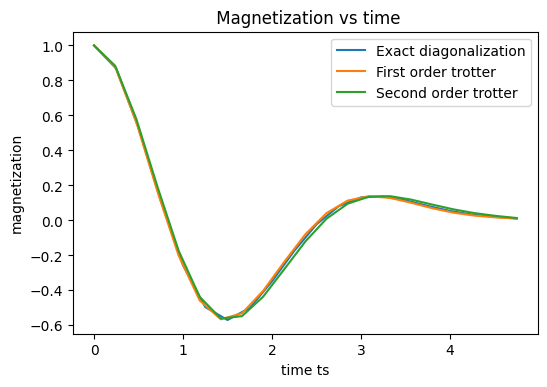

In [174]:

plt.figure(dpi=(100))
plt.plot(ts, magnetization, label='Exact diagonalization')
plt.plot(ts_simulate, mgntz_list_first, label='First order trotter')
plt.plot(ts_simulate, mgntz_list_second, label='Second order trotter')
plt.title(' Magnetization vs time')
plt.xlabel('time ts')
plt.ylabel('magnetization')
plt.legend()
plt.show()


In [ ]:
# for dt = 0.25 the results are already quite good.
# for dt = 0.5 it looked still woozy


In [181]:
# exercise 8

simulator = cirq.Simulator()
qubits = cirq.LineQubit.range(L)
ops = [cirq.I(q) for q in qubits]
#mgntz = cirq.Circuit([ops, ops]) #initializing the circuit in all ups
mgntz = cirq.Circuit(ops)

result = simulator.simulate(mgntz)
state = result.final_state_vector

print(state.conj())

state = state/np.linalg.norm(state) # in case not normalized for large system

print(len(state))

[1.-0.j 0.-0.j 0.-0.j ... 0.-0.j 0.-0.j 0.-0.j]
1024


In [204]:
def compute_losch(L, g, dt, t, approx='one'):
    
    N = int(t/dt)

    simulator = cirq.Simulator()
    qubits = cirq.LineQubit.range(L)
    ops = [cirq.I(q) for q in qubits]

    losch = cirq.Circuit(ops)

    gs_zero, gs_one = np.zeros(2**L), np.zeros(2**L)

    print(len(gs_zero))

    gs_zero[0] = 1
    gs_one[-1] = 1

    losch_zero = [] # projection onto the zero ground state
    losch_one = [] # projection onto the one ground state

    for i in range(N+1):

        result = simulator.simulate(losch)
        state = result.final_state_vector

        state = state/np.linalg.norm(state) # in case not normalized for large system

        print(len(state))

        projection0 = abs(np.inner(gs_zero.conj(), state))**2
        projection1 = abs(np.inner(gs_one.conj(), state))**2

        losch_zero.append(projection0)
        losch_one.append(projection1)

        print('iteration: ',i)
        if approx == 'one':
            evolve_basic(losch,qubits,g,dt) 
        elif approx == 'second':
            evolve_symmetric(losch,qubits,g,dt) 
        else:
            raise 'not a valid mode'

    losch_total = np.array(losch_zero) + np.array(losch_one)

    return losch_zero, losch_one, losch_total

In [205]:
Ls = [6,8,10,12]

lambda0 =[]
lambda1 = []
lambdat = []

for L in Ls:
    print(L)
    losch_zero, losch_one, losch_total = compute_losch(L=L, g=2.0, dt=0.25, t=5)
    lambda0.append(losch_zero)
    lambda1.append(losch_one)
    lambdat.append(losch_total)

6
64
64
iteration:  0
64
iteration:  1
64
iteration:  2
64
iteration:  3
64
iteration:  4
64
iteration:  5
64
iteration:  6
64
iteration:  7
64
iteration:  8
64
iteration:  9
64
iteration:  10
64
iteration:  11
64
iteration:  12
64
iteration:  13
64
iteration:  14
64
iteration:  15
64
iteration:  16
64
iteration:  17
64
iteration:  18
64
iteration:  19
64
iteration:  20
8
256
256
iteration:  0
256
iteration:  1
256
iteration:  2
256
iteration:  3
256
iteration:  4
256
iteration:  5
256
iteration:  6
256
iteration:  7
256
iteration:  8
256
iteration:  9
256
iteration:  10
256
iteration:  11
256
iteration:  12
256
iteration:  13
256
iteration:  14
256
iteration:  15
256
iteration:  16
256
iteration:  17
256
iteration:  18
256
iteration:  19
256
iteration:  20
10
1024
1024
iteration:  0
1024
iteration:  1
1024
iteration:  2
1024
iteration:  3
1024
iteration:  4
1024
iteration:  5
1024
iteration:  6
1024
iteration:  7
1024
iteration:  8
1024
iteration:  9
1024
iteration:  10
1024
iteration

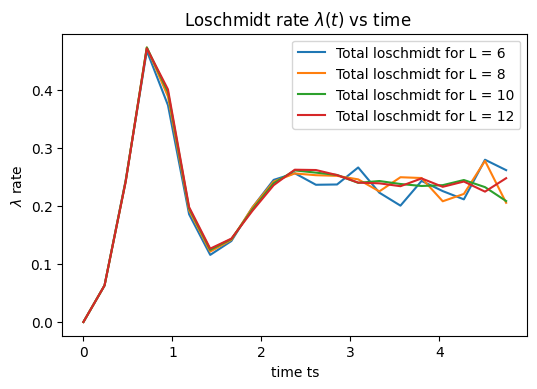

In [214]:
plt.figure(dpi=(100))
for i, L in enumerate(Ls):
    plt.plot(ts_simulate, -np.log(lambdat[i])/L, label='Total loschmidt for L = {}'.format(L))
plt.title(' Loschmidt rate $\lambda(t)$ vs time')
plt.xlabel('time ts')
plt.ylabel('$\lambda$ rate')
plt.legend()
plt.show()

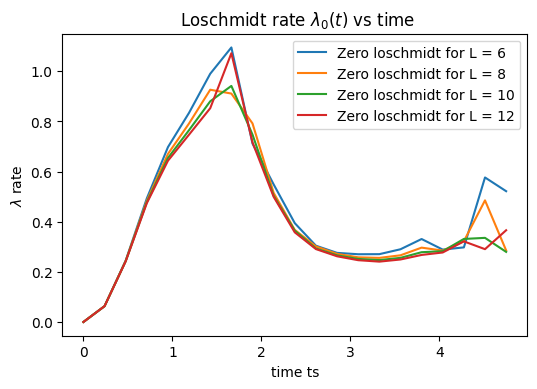

In [215]:
plt.figure(dpi=(100))
for i, L in enumerate(Ls):
    plt.plot(ts_simulate, -np.log(lambda0[i])/L, label='Zero loschmidt for L = {}'.format(L))
plt.title(' Loschmidt rate $\lambda_0(t)$ vs time')
plt.xlabel('time ts')
plt.ylabel('$\lambda$ rate')
plt.legend()
plt.show()

/var/folders/_n/xw2mchz92t9_fcbxg7lwsdwh0000gn/T/ipykernel_9140/1456176578.py:3: RuntimeWarning: divide by zero encountered in log
  plt.plot(ts_simulate, -np.log(lambda1[i])/L, label='One loschmidt for L={}'.format(L))


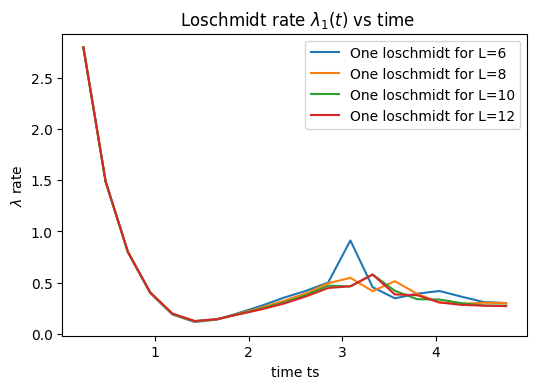

In [216]:
plt.figure(dpi=(100))
for i, L in enumerate(Ls):
    plt.plot(ts_simulate, -np.log(lambda1[i])/L, label='One loschmidt for L={}'.format(L))
plt.title(' Loschmidt rate $\lambda_1(t)$ vs time')
plt.xlabel('time ts')
plt.ylabel('$\lambda$ rate')
plt.legend()
plt.show()